In [11]:
import numpy as np
import matplotlib.pyplot as plt
from citros import CitrosDB
from prettytable import PrettyTable, ALL

In [12]:
def get_data(sid: int) -> [dict, dict, list, list, dict, dict, list]:
    '''
        extract the relevant data from citros
    '''
    position = citros.topic('/fmu/out/vehicle_local_position').sid(sid).data(['data.x', 'data.y', 'data.z'])
    velocity = citros.topic('/fmu/out/vehicle_local_position').sid(sid).data(['data.vx', 'data.vy', 'data.vz'])
    position['data.z'] = position['data.z'].apply(lambda x: x * -1.0)

    setpoints = citros.topic('/fmu/in/trajectory_setpoint').sid(sid).data('data.position')
    offboard_state = citros.topic('/offboard/state').sid(sid).data('data.data')

    wind_raw = citros.topic('/config').sid(sid).data('data.world.ros__parameters.windVelocityMean')
    wind = [x for x in wind_raw['data.world.ros__parameters.windVelocityMean'] if "nan" not in str(x)][0]

    return position, velocity, setpoints, offboard_state, wind

def _find_nearest(array: list, value: float) -> int:
    '''
        return the index of the nearest element to value in a given array.
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def _generate_position_error(position: dict, offboard_state: dict) -> list:
    '''
        return an array contain the position error during the flight

        setpoints = {
            "P1": [0.0, 0.0, -5.0],
            "P2": [10.0, 0.0, -5.0],
            "P3": [10.0, 10.0, -5.0],
            "P4": [0.0, 10.0, -5.0],
        }
    '''

    position_error = {"data": [],
                      "time": []}

    for index, row in offboard_state.iterrows():
        t = _find_nearest(position['time'], row['time'])

        if index == 0:
            t_0 = t

        if "P1" in row['data.data']:
            error = 0.0 - position['data.x'][t]
        
        if "P2" in row['data.data']:
            error = 0.0 - position['data.y'][t]

        if "P3" in row['data.data']:
            error = 10.0 - position['data.x'][t]

        if "P4" in row['data.data']:
            error = 10.0 - position['data.y'][t]

        position_error['data'].append(error)
        position_error['time'].append(index * 0.02)
    return position_error

def plot_xy(ax, position: dict) -> None:
    '''
        plot x-y trajectory of the drone
    '''
    ax.plot(position['data.x'], position['data.y'])

def plot_position_error(ax, position_error: dict) -> None:
    '''
        plot the error between the current position and the setpoints
    '''
    ax.plot(position_error['time'], position_error['data'])

def plot_xyz(ax, position: dict) -> None:
    '''
        plot the trajectory of the drone
    '''
    ax.plot(position['data.x'], position['data.y'], position['data.z'])


def handle_axes(ax_xy, ax_errors, ax_xyz) -> None:
    '''
        adding utilites to the axes
    '''

    ax_xy.set_title("X vs. Y")
    ax_xy.text(0.5, 0.5, "P1")
    ax_xy.text(9.5, 0.5, "P2")
    ax_xy.text(9.5, 9.5, "P3")
    ax_xy.text(0.5, 9.5, "P4")
    ax_xy.grid()

    ax_errors.set_xlabel("Time [sec]")
    ax_errors.set_ylabel("Position Error [m]")
    ax_errors.grid()

    ax_xyz.set_title("Trajectory")
    ax_xyz.set_xlabel("X")
    ax_xyz.set_ylabel("Y")
    ax_xyz.set_zlabel("Z")
    ax_xyz.grid(False)

    ax_xyz.xaxis.pane.fill = False
    ax_xyz.yaxis.pane.fill = False
    ax_xyz.zaxis.pane.fill = False

    ax_xyz.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax_xyz.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax_xyz.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    ax_xyz.set_box_aspect(aspect=None, zoom=0.9)

{'size': '68 MB', 'sid_count': 5, 'sid_list': [0, 1, 2, 3, 4], 'topic_count': 8, 'topic_list': ['/config', '/fmu/in/offboard_control_mode', '/fmu/in/trajectory_setpoint', '/fmu/in/vehicle_command', '/fmu/out/vehicle_control_mode', '/fmu/out/vehicle_local_position', '/fmu/out/vehicle_status', '/offboard/state'], 'message_count': 71806}
[INFO] Complete 0.0 % of the loop ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


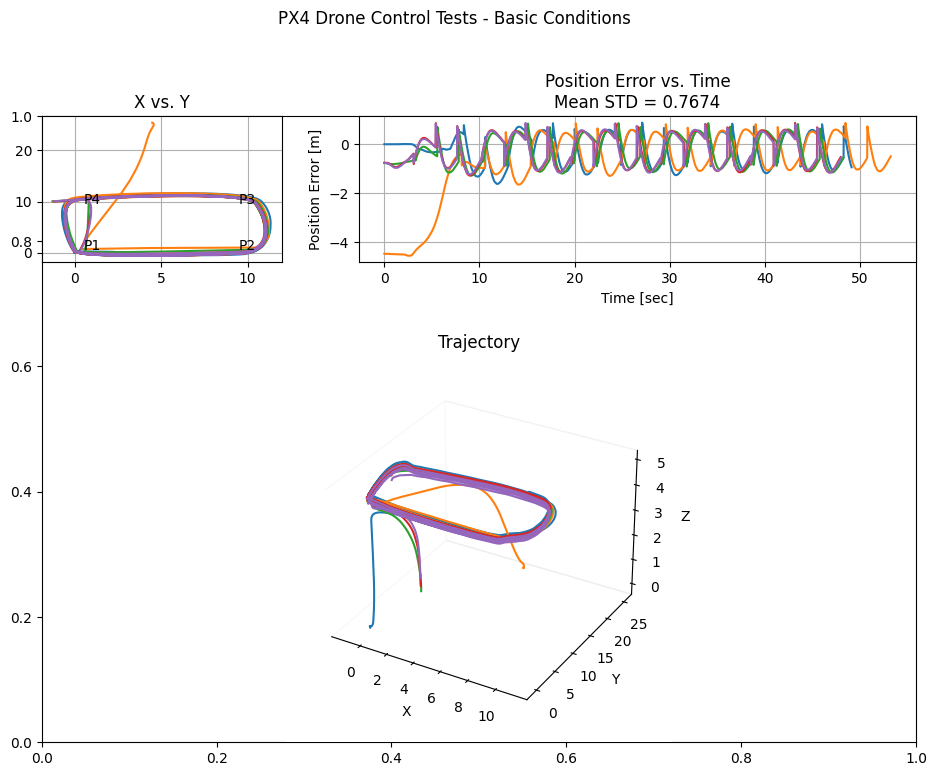

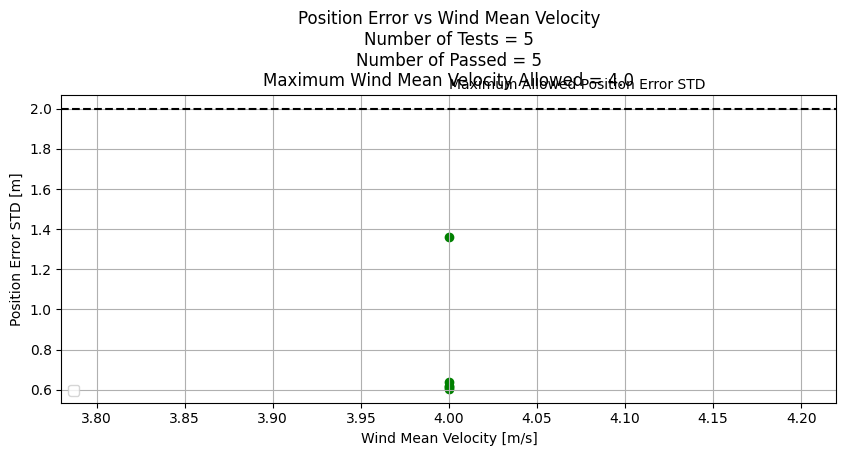

In [13]:
fig, _ = plt.subplots(figsize=(10, 8))
gs = plt.GridSpec(3, 3)

ax_xy = fig.add_subplot(gs[0, 0])
ax_errors = fig.add_subplot(gs[0, 1:])
ax_xyz = fig.add_subplot(gs[1:, :], projection='3d')

# initialize the list of stds
std_of_the_error = []
wind_mean_velocity = []

run = 'wind_mean_velocity_uniform'

citros = CitrosDB(simulation = 'simulation_offboard_position_control', batch = 'drone_offboard_simulation')

print(citros.info())

for i in range(citros.info()["sid_count"]):
    position, velocity, setpoints, offboard_state, wind = get_data(i)
    error = _generate_position_error(position, offboard_state)

    plot_xy(ax_xy, position)
    plot_position_error(ax_errors, error)
    plot_xyz(ax_xyz, position)
    
    std_of_the_error.append(np.std(error['data']))
    wind_mean_velocity.append(wind)

    if i % 5 == 0:
        print(f'[INFO] Complete {(i/citros.info()["sid_count"])*100} % of the loop ...')

# add utilities to the plots
handle_axes(ax_xy, ax_errors, ax_xyz)

# calculate the mean STD
mean_std = np.mean(std_of_the_error)

ax_errors.set_title(f"Position Error vs. Time\nMean STD = {mean_std:.4}")
fig.suptitle('PX4 Drone Control Tests - Basic Conditions')
fig.tight_layout(pad=2.0)

plt.figure(figsize=(10, 4))
passed_test = 0
passed_winds = []
for i in range(len(wind_mean_velocity)):
    if std_of_the_error[i] < 2.0:
        color = 'green'
        passed_test += 1
        passed_winds.append(wind_mean_velocity[i])
    else:
        color = 'red'
    plt.scatter(wind_mean_velocity[i], std_of_the_error[i], c=color)

plt.axhline(y=2.0, c='black', ls='--')
plt.text(min(wind_mean_velocity), 2.1, 'Maximum Allowed Position Error STD', fontsize=10)

plt.title(f'Position Error vs Wind Mean Velocity\nNumber of Tests = {len(wind_mean_velocity)}\nNumber of Passed = {passed_test}\nMaximum Wind Mean Velocity Allowed = {max(passed_winds):.3}')
plt.xlabel('Wind Mean Velocity [m/s]')
plt.ylabel('Position Error STD [m]')
plt.grid(True)
plt.legend()